In [16]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [17]:
import math
import matplotlib.colors as mcolors
import ipywidgets as widgets
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import clear_output
from rich import print as rprint
from torch.utils.data import DataLoader, Subset

from analysis.utils import load_model
from koopmann.aesthetics import ibmplexsans, kill_axes, kill_ticks
from koopmann.data import DatasetConfig, get_dataset_class
from koopmann.shape_metrics import build_acts_dict, preprocess_acts
from koopmann.utils import get_device, set_seed

set_seed(21)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Control panel

In [18]:
file_dir = "/Users/nsa325/koopmann_model_saves"
data_root = "/Users/nsa325/datasets/"
model_name = "resmlp_mnist"
device = get_device()

In [19]:
model, model_metadata = load_model(file_dir, model_name)
model.hook_model().eval().to(device)
rprint("MLP Metadata: ", model_metadata)

MLP Metadata: 
{
    'batchnorm': True,
    'bias': True,
    'created_at': '2025-04-09T02:41:58.432513',
    'dataset': 'MNISTDataset',
    'hidden_config': [784, 784, 784, 784],
    'in_features': 784,
    'model_class': 'ResMLP',
    'nonlinearity': 'relu',
    'out_features': 10,
    'stochastic_depth_mode': 'batch',
    'stochastic_depth_prob': 0.0
}

In [20]:
# Build dataset
dataset_config = DatasetConfig(
    dataset_name=model_metadata["dataset"], num_samples=5_000, split="train", seed=42
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config, root=data_root)

# Grab subset of dataset
subset_size = 2_000
if subset_size:
    subset_indices = list(range(0, subset_size))
    subset = Subset(dataset, subset_indices)

# Make dataloader
batch_size = 5_000
batch_size = min(subset_size, batch_size) if subset_size else batch_size
dataloader = DataLoader(subset if subset_size else dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Collect activations
original_act_dict = build_acts_dict(
    data_train_loader=dataloader, model=model, only_first_last=False, device=device
)

# Preprocess activations
SVD_DIM = 3
processed_act_dict = preprocess_acts(
    original_act_dict=original_act_dict,
    svd_dim=SVD_DIM,
    whiten_alpha=1,
    device=device,
)

Processing activations: 100%|██████████| 5/5 [00:00<00:00, 252.16it/s]


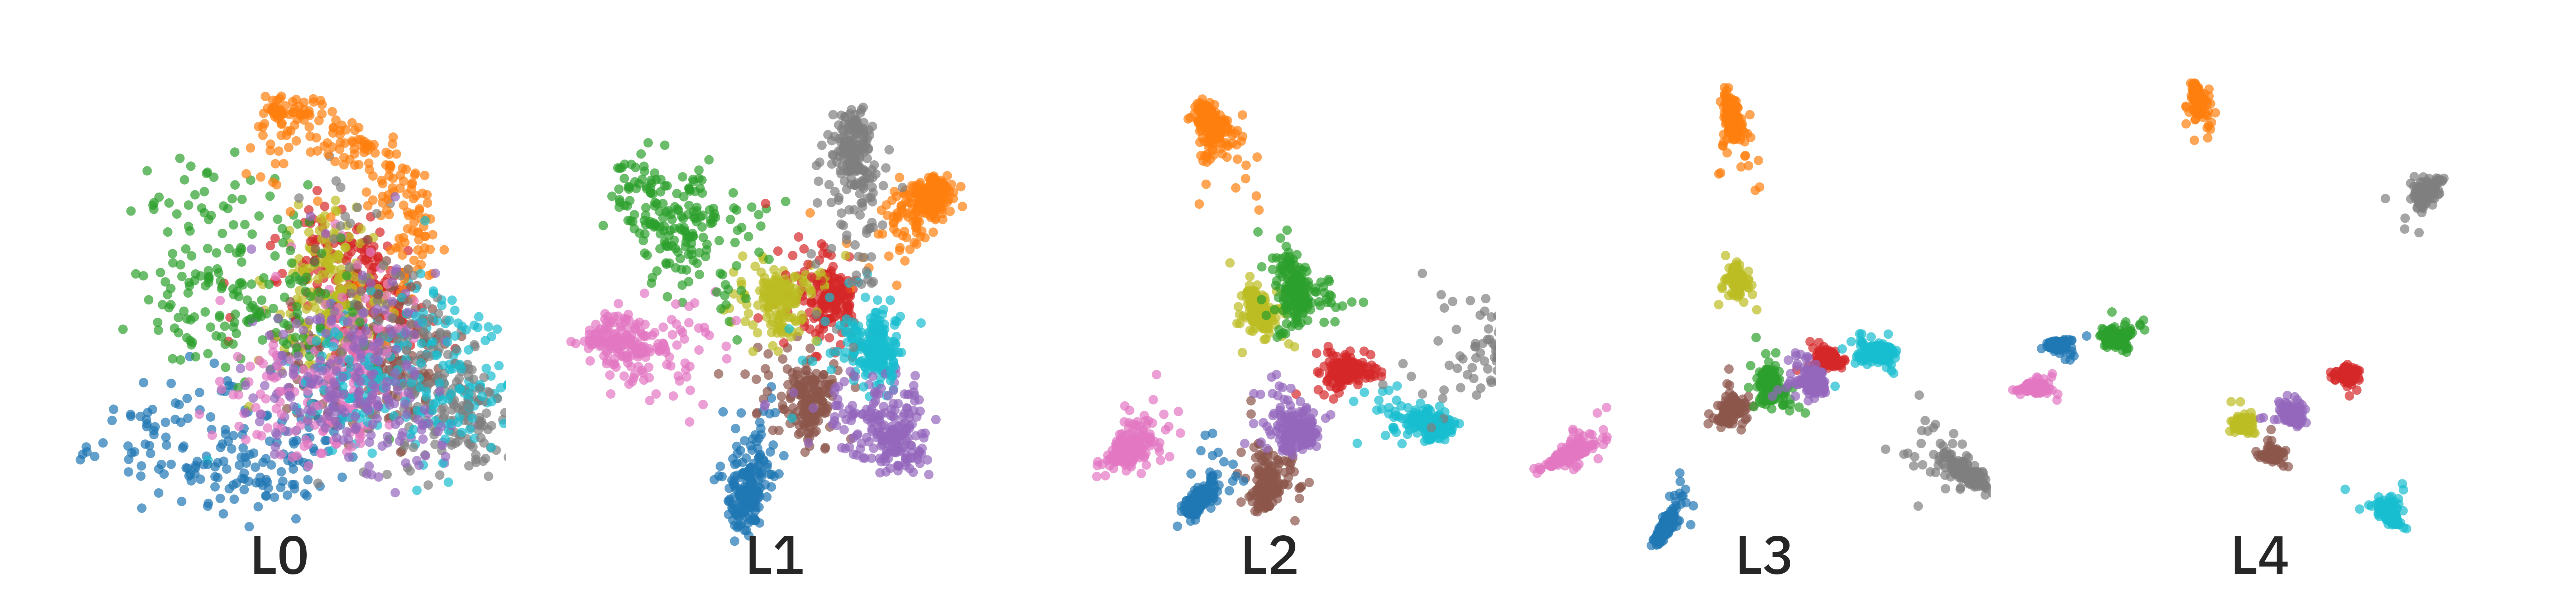

In [ ]:
# Data
keys = list(processed_act_dict.keys())
labels = [str(t) for t in dataset.labels[:subset_size]]
classes = sorted(set(labels))

# Colors
palette = list(mcolors.TABLEAU_COLORS.values())
# palette = ["#fc9918", "#a779aa", "#4c3191"]  # yinyang palette

colors = [palette[classes.index(cat) % len(palette)] for cat in labels]

# Create grid of plots
n_cols = 5
n_rows = math.ceil(len(keys) / n_cols)
fig = plt.figure(figsize=(5 * n_cols, 5 * n_rows), dpi=300)
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, wspace=-0.3, hspace=0.1)
gs.update(left=0, right=1, top=1, bottom=0)

# Create plots
for i, key in enumerate(keys):
    # Plot
    coords = processed_act_dict[key].cpu().numpy()
    ax = fig.add_subplot(gs[i // n_cols, i % n_cols], projection="3d")
    ax.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2], s=40, c=colors, alpha=0.7, edgecolors="none"
    )
    ax.text2D(
        0.5, 0.05, f"L{key}", fontsize=36, font=ibmplexsans, ha="center", transform=ax.transAxes
    )

    # Clean appearance
    kill_ticks(ax)
    kill_axes(ax)
    ax.margins(0, 0, 0)  # Remove any internal margins

    # Set consistent view angle
    ax.view_init(elev=-20, azim=-30)
    ax.set_box_aspect([1, 1, 1], zoom=1.3)

# Save with minimal borders
# plt.savefig(f"{model_name}_seq.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
# def update_plot(change):
#     # First clear everything
#     clear_output(wait=True)

#     # Re-display the slider first (so it appears above the plot)
#     display(layer_slider)

#     # Get the selected layer index and key
#     coords = processed_act_dict[layer_keys[layer_slider.value]].cpu()
#     target_categories = [str(t) for t in dataset.labels[:subset_size]]

#     # Create and display the new plot
#     fig = px.scatter_3d(
#         x=coords[:, 0],
#         y=coords[:, 1],
#         z=coords[:, 2],
#         color=target_categories,
#         color_discrete_sequence=px.colors.qualitative.T10,
#     )
#     fig.update_traces(marker_size=2)
#     fig.update_layout(showlegend=False)
#     fig.show()


# # Get the layer keys and convert to a list for indexing
# layer_keys = list(processed_act_dict.keys())
# layer_slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=len(layer_keys) - 1,
#     step=1,
#     description="Layer:",
#     continuous_update=False,  # Only update when slider is released
# )

# # Connect slider to update function
# layer_slider.observe(update_plot, names="value")
# update_plot(None)